
##### PINN / Digital Twin for Falling Body with Quadratic Drag
- Input: time t
- Outputs: velocity v(t), position y(t)

In [28]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Parameter definiton

m = 80.0          # kg
g = 9.81          # m/s^2
gamma = 0.31      # kg/m
k = gamma / m
v_terminal = math.sqrt(m * g / gamma)   # sqrt(m g / gamma)

print(f"Terminal velocity (theoretical) = {v_terminal:.2f} m/s")

Terminal velocity (theoretical) = 50.32 m/s


In [ ]:
# Create the analytical solution for both - genenrating data and checking final PINN results

def analytic_v(t):
    """
    t: torch tensor of shape (N, 1)
    v(t) = v_T * tanh( (g / v_T) * t )
    """
    a = g / v_terminal
    return v_terminal * torch.tanh(a * t)

def analytic_y(t):
    """
    y(t) = (v_T^2 / g) * ln(cosh( (g / v_T) * t ))
    """
    a = g / v_terminal
    return (v_terminal**2 / g) * torch.log(torch.cosh(a * t))

In [ ]:
# Generate synthetic data
# Time range for reference (e.g. 0 to 15 s)

t_max = 15.0

# (A) Collocation points for physics loss (covers most of the dynamics)
N_phys = 2000
t_phys = torch.linspace(0.0, t_max, N_phys).view(-1, 1).to(device)

# (B) Sparse "measurement" data near the start (e.g. first 4 seconds)
N_data = 25
t_data = torch.linspace(0.0, 4.0, N_data).view(-1, 1)
v_data = analytic_v(t_data)
y_data = analytic_y(t_data)

t_data = t_data.to(device)
v_data = v_data.to(device)
y_data = y_data.to(device)

# Also define t=0 for initial condition loss
t_ic = torch.zeros((1, 1), device=device)  # shape (1,1)
v_ic = torch.zeros((1, 1), device=device)
y_ic = torch.zeros((1, 1), device=device)

In [ ]:
# PINN architecture

class PINN_FallingBody(nn.Module):
    def __init__(self, n_hidden=4, n_neurons=32):
        super().__init__()
        layers = []
        input_dim = 1      # t
        output_dim = 2     # [v, y]

        # Input layer
        layers.append(nn.Linear(input_dim, n_neurons))
        layers.append(nn.Tanh())

        # Hidden layers
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.Tanh())

        # Output layer
        layers.append(nn.Linear(n_neurons, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, t):
        """
        t: (N,1) tensor of time
        Returns:
            v_pred: (N,1)
            y_pred: (N,1)
        """
        out = self.net(t)
        v = out[:, 0:1]
        y = out[:, 1:2]
        return v, y

model = PINN_FallingBody().to(device)


In [ ]:
# Loss functions

mse = nn.MSELoss()

def physics_residuals(t):
    """
    Compute the residuals of the ODEs:
      dv/dt - (g - gamma/m * v^2) = 0
      dy/dt - v = 0
    """
    t = t.clone().detach().requires_grad_(True)
    v_pred, y_pred = model(t)

    # dv/dt
    dv_dt = torch.autograd.grad(
        v_pred,
        t,
        grad_outputs=torch.ones_like(v_pred),
        create_graph=True
    )[0]

    # dy/dt
    dy_dt = torch.autograd.grad(
        y_pred,
        t,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]

    # ODE residuals
    # dv/dt = g - (gamma/m) * v^2
    ode_v = dv_dt - (g - (gamma / m) * v_pred**2)

    # dy/dt = v
    ode_y = dy_dt - v_pred

    return ode_v, ode_y


def pinn_loss():
    # Physics loss on collocation points
    ode_v_res, ode_y_res = physics_residuals(t_phys)
    loss_phys_v = mse(ode_v_res, torch.zeros_like(ode_v_res))
    loss_phys_y = mse(ode_y_res, torch.zeros_like(ode_y_res))
    loss_phys = loss_phys_v + loss_phys_y

    # Data loss on sparse measurements
    v_pred_data, y_pred_data = model(t_data)
    loss_data_v = mse(v_pred_data, v_data)
    loss_data_y = mse(y_pred_data, y_data)
    loss_data = loss_data_v + loss_data_y

    # Initial condition loss
    v_pred_ic, y_pred_ic = model(t_ic)
    loss_ic_v = mse(v_pred_ic, v_ic)
    loss_ic_y = mse(y_pred_ic, y_ic)
    loss_ic = loss_ic_v + loss_ic_y

    # Combine with some weights (tunable)
    w_phys = 20.0
    w_data = 1.0
    w_ic   = 5.0


    loss = w_phys * loss_phys + w_data * loss_data + w_ic * loss_ic

    return loss, {
        "loss_phys": loss_phys.item(),
        "loss_data": loss_data.item(),
        "loss_ic": loss_ic.item()
    }




In [ ]:
# Training Loop

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 30000

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    loss, parts = pinn_loss()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Epoch {epoch:5d}, "
            f"total loss = {loss.item():.6f}, "
            f"phys = {parts['loss_phys']:.6f}, "
            f"data = {parts['loss_data']:.6f}, "
            f"ic = {parts['loss_ic']:.6f}"
        )

print("Training finished.")


Epoch   500, total loss = 2692.369141, phys = 95.145721, data = 783.869385, ic = 1.117068
Epoch  1000, total loss = 2392.043701, phys = 96.076691, data = 467.560486, ic = 0.589883
Epoch  1500, total loss = 2248.713379, phys = 96.489410, data = 316.592346, ic = 0.466565
Epoch  2000, total loss = 2160.634521, phys = 95.794052, data = 243.438385, ic = 0.262987
Epoch  2500, total loss = 2092.721436, phys = 94.558327, data = 199.986328, ic = 0.313714
Epoch  3000, total loss = 2036.119995, phys = 93.263145, data = 169.771027, ic = 0.217212
Epoch  3500, total loss = 1986.906372, phys = 91.869568, data = 148.463196, ic = 0.210384
Epoch  4000, total loss = 1941.336182, phys = 90.349945, data = 133.366302, ic = 0.194201
Epoch  4500, total loss = 1895.675049, phys = 88.578812, data = 123.146095, ic = 0.190560
Epoch  5000, total loss = 1848.968018, phys = 86.743179, data = 113.291199, ic = 0.162655
Epoch  5500, total loss = 1742.869995, phys = 79.997269, data = 141.919174, ic = 0.201099
Epoch  600

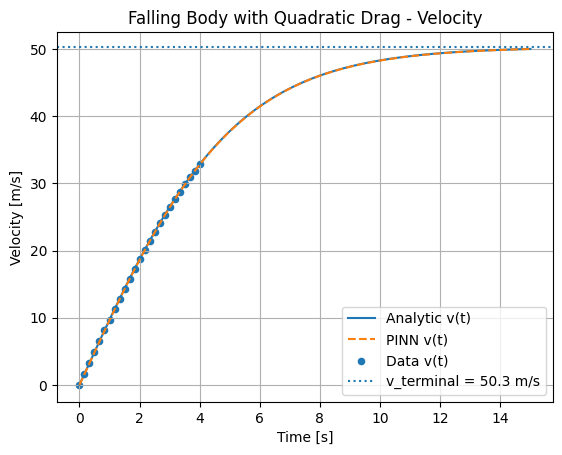

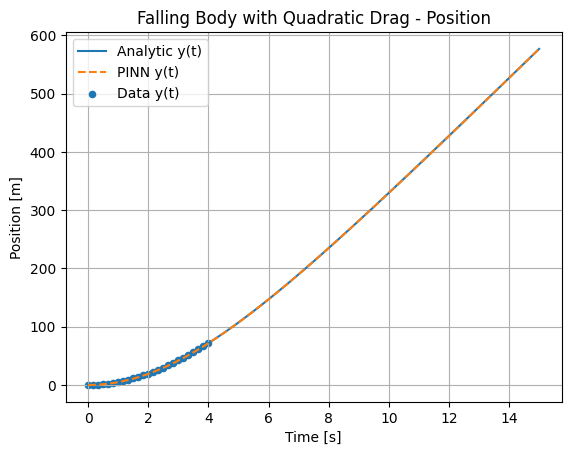

In [ ]:
# Evaluation of PINN performance
model.eval()

# Dense time grid for plotting
t_plot = torch.linspace(0.0, t_max, 400).view(-1, 1).to(device)

with torch.no_grad():
    v_pinn, y_pinn = model(t_plot)

v_true = analytic_v(t_plot).to(device)
y_true = analytic_y(t_plot).to(device)

t_np = t_plot.cpu().numpy().flatten()
v_pinn_np = v_pinn.cpu().numpy().flatten()
y_pinn_np = y_pinn.cpu().numpy().flatten()
v_true_np = v_true.cpu().numpy().flatten()
y_true_np = y_true.cpu().numpy().flatten()

# Plot velocity
plt.figure()
plt.plot(t_np, v_true_np, label="Analytic v(t)")
plt.plot(t_np, v_pinn_np, "--", label="PINN v(t)")
plt.scatter(t_data.cpu().numpy(), v_data.cpu().numpy(), s=20, label="Data v(t)")
plt.axhline(v_terminal, linestyle=":", label=f"v_terminal = {v_terminal:.1f} m/s")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.title("Falling Body with Quadratic Drag - Velocity")
plt.legend()
plt.grid(True)

# Plot position
plt.figure()
plt.plot(t_np, y_true_np, label="Analytic y(t)")
plt.plot(t_np, y_pinn_np, "--", label="PINN y(t)")
plt.scatter(t_data.cpu().numpy(), y_data.cpu().numpy(), s=20, label="Data y(t)")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title("Falling Body with Quadratic Drag - Position")
plt.legend()
plt.grid(True)

plt.show()
